# Trimming Messages

In [1]:
from langgraph.graph import START, END, StateGraph, add_messages, MessagesState
from typing_extensions import TypedDict
from langchain_ollama import ChatOllama
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage, RemoveMessage
from collections.abc import Sequence
from typing import Literal, Annotated

### Define the Nodes

In [2]:
import os
os.environ.setdefault("no_proxy", "127.0.0.1,localhost")
os.environ.setdefault("HTTPX_NO_PROXY", "127.0.0.1,localhost")
OLLAMA_URL = os.getenv("OLLAMA_URL", "http://127.0.0.1:11434")

model_name = "gemma3" #"llama3.2:3b"

max_tokens = 100
llm = ChatOllama(model=model_name, num_predict=max_tokens, temperature=0)

In [3]:
def ask_question(state: MessagesState) -> MessagesState:

    print(f"\n-------> ENTERING ask_question:")
    for i in state["messages"]:
        i.pretty_print()

    question = "What is your question?"
    print(question)

    return MessagesState(messages = [AIMessage(question), HumanMessage(input())])

In [4]:
def chatbot(state: MessagesState) -> MessagesState:

    print(f"\n-------> ENTERING chatbot:")
    for i in state["messages"]:
        i.pretty_print()

    response = llm.invoke(state["messages"])
    response.pretty_print()

    return MessagesState(messages = [response])

In [5]:
def ask_another_question(state: MessagesState) -> MessagesState:

    print(f"\n-------> ENTERING ask_another_question:")
    for i in state["messages"]:
        i.pretty_print()

    question = "Would you like to ask one more question (yes/no)?"
    print(question)

    return MessagesState(messages = [AIMessage(question), HumanMessage(input())])

In [6]:
def trim_messages(state: MessagesState) -> MessagesState:
    print(f"\n-------> ENTERING trim_messages:")

    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:-5]]

    return MessagesState(messages = remove_messages)

### Define the Routing Function

In [7]:
def routing_function(state: MessagesState) -> Literal["trim_messages", "__end__"]:
    
    if state["messages"][-1].content == "yes":
        return "trim_messages"
    else:
        return "__end__"

### Define the Graph

In [9]:
graph = StateGraph(MessagesState)

In [10]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)
graph.add_node("trim_messages", trim_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function)
graph.add_edge("trim_messages", "ask_question")

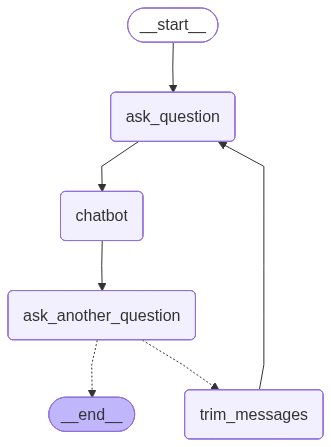

In [11]:
graph_compiled = graph.compile()
graph_compiled

### Test the Graph

In [14]:
graph_compiled.invoke(MessagesState(messages = []))


-------> ENTERING ask_question:
What is your question?

-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

result = 1+1
================================== Ai Message ==================================

Okay, let's evaluate that:

1 + 1 = 2

Therefore, `result` would be assigned the value **2**.

-------> ENTERING ask_another_question:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

result = 1+1
================================== Ai Message ==================================

Okay, let's evaluate that:

1 + 1 = 2

Therefore, `result` would be assigned the value **2**.
Would you like to ask one more question (yes/no)?

-------> ENTERING trim_messages:

-------> ENTERING ask_question:
======

{'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='570cdaf9-ef87-4563-bf9b-d05423378b4f'),
  HumanMessage(content='result = result + 1', additional_kwargs={}, response_metadata={}, id='49d0efce-bfef-49a9-a670-f6f78c8bd2ee'),
  AIMessage(content="Okay, let's break that down:\n\n*   Initially, `result` is 3 (from the previous calculation).\n*   `result = result + 1` means `result = 3 + 1`.\n*   `3 + 1 = 4`\n\nTherefore, `result` would be assigned the value **4**.\n\nDo you want to try another calculation?\n", additional_kwargs={}, response_metadata={'model': 'gemma3', 'created_at': '2025-11-18T07:45:02.6267492Z', 'done': True, 'done_reason': 'stop', 'total_duration': 11196604100, 'load_duration': 305729300, 'prompt_eval_count': 153, 'prompt_eval_duration': 1407817300, 'eval_count': 84, 'eval_duration': 9440143600, 'model_name': 'gemma3'}, id='run--bc8e1db4-19b9-4e7f-b7ae-717267a0ed68-0', usage_metadata={'input_tokens': 153, 'output_t